In [3]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Load Pandas Dataframe

In [11]:
albums_df = pd.read_pickle("./albums_df_large_img.pkl")

albums_df.head()

,artist_id,artist_name,album_id,album_name,album_popularity,genres,filepath,rap,rock,pop
0,5me0Irg2ANcsgc93uaYrpb,The Notorious B.I.G.,7dRdaGSxgcBdJnrOviQRuB,Life After Death (2014 Remastered Edition),78,[rap],.\images\7dRdaGSxgcBdJnrOviQRuB.jpg,1,0,0
1,36QJpDe2go2KgaRleHCDTp,Led Zeppelin,6P5QHz4XtxOmS5EuiGIPut,Led Zeppelin III (Remaster),74,[rock],.\images\6P5QHz4XtxOmS5EuiGIPut.jpg,0,1,0
2,5WUlDfRSoLAfcVSX1WnrxN,Sia,77jAfTh3KH9K2reMOmTgOh,This Is Acting,74,[pop],.\images\77jAfTh3KH9K2reMOmTgOh.jpg,0,0,1
5,246dkjvS1zLTtiykXe5h60,Post Malone,4g1ZRSobMefqF6nelkgibi,Hollywood's Bleeding,93,[rap],.\images\4g1ZRSobMefqF6nelkgibi.jpg,1,0,0
8,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,Oops!... I Did It Again,76,[rap],.\images\5PmgtkodFl2Om3hMXONDll.jpg,1,0,0


## Load images to dataframe

Load images and resize them to 320 x 320. 

Each image is represented as a vector of 102.400 dimensions.

In [14]:
from skimage.io import imread
from skimage.transform import resize


image_list = []

for img_path in albums_df['filepath']:
    image = imread(img_path)
    resized_image = resize(image, (320,320)) 
    image_list.append(resized_image)
    
albums_df['img'] = image_list

## 1. Face Detection

The first feature to be extracted is the presence of face(s) in the album cover image. 
OpenCV's algorithm is currently using the following Haar-like features which are the input to the basic classifiers. 

Parameters:
- **image** : Matrix of the type CV_8U containing an image where objects are detected.

- **scaleFactor** : Parameter specifying how much the image size is reduced at each image scale. Suppose, the scale factor is 1.03, it means we're using a small step for resizing, i.e. reduce size by 3 %, we increase the chance of a matching size with the model for detection is found, while it's expensive. We're using 1.07 in the code. 

- **minNeighbors** : Parameter specifying how many neighbors each candidate rectangle should have to retain it. This parameter will affect the quality of the detected faces: higher value results in less detections but with higher quality. We're using 15 in the code.

Visualize the results for a random sample of images using OpenCV pre-trained face classifier.

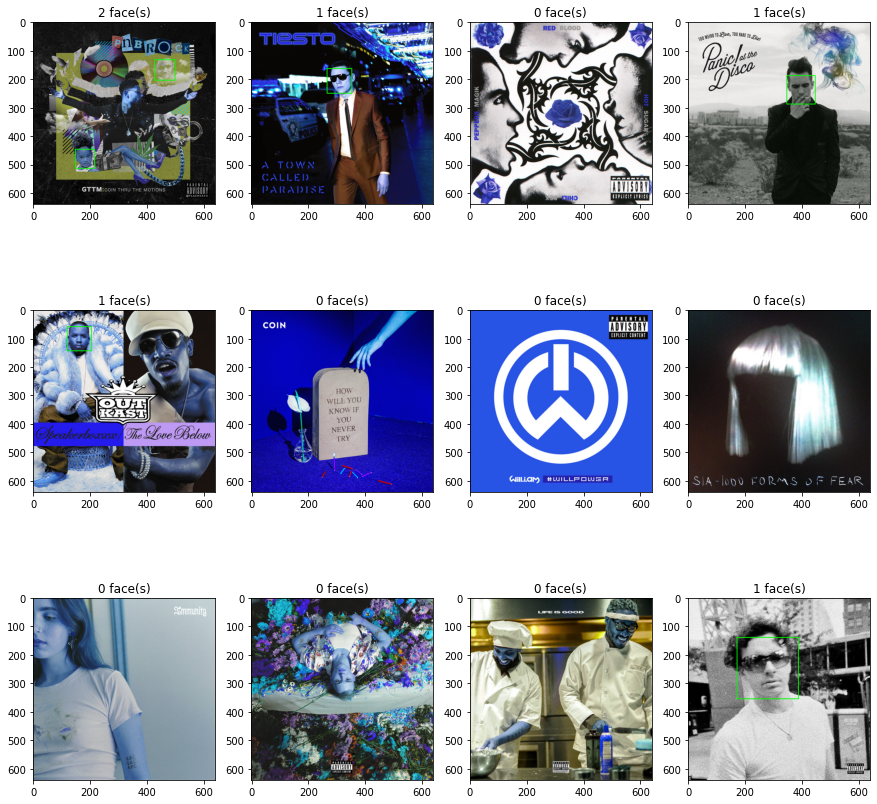

In [136]:
image_samples = albums_df.filepath.sample(n = 12) 

# OpenCV Face Classifier
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')    
scaleFactor = 1.07
minNeighbors = 15

fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for plot_number, filepath in enumerate(image_samples):
    image = cv2.imread(filepath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(gray, scaleFactor, minNeighbors)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    ax = fig.add_subplot(rows, columns, plot_number+1, )
    ax.title.set_text(f"{len(faces)} face(s)")
    plt.imshow(image)
    
plt.show()

Create the feature `has_face`

- **1** : if face(s) is present in the image
- **0** : otherwise

In [139]:
# OpenCV Face Classifier
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')    
scaleFactor = 1.07
minNeighbors = 15

has_face_list = []

for index, filepath in enumerate(albums_df.filepath):
    
    has_face = 0
    
    image = cv2.imread(filepath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(gray, scaleFactor, minNeighbors)
    
    if len(faces) > 0:
        has_face = 1
    has_face_list.append(has_face)
        
albums_df['has_face'] = has_face_list

Text(0.5, 0, 'Index')

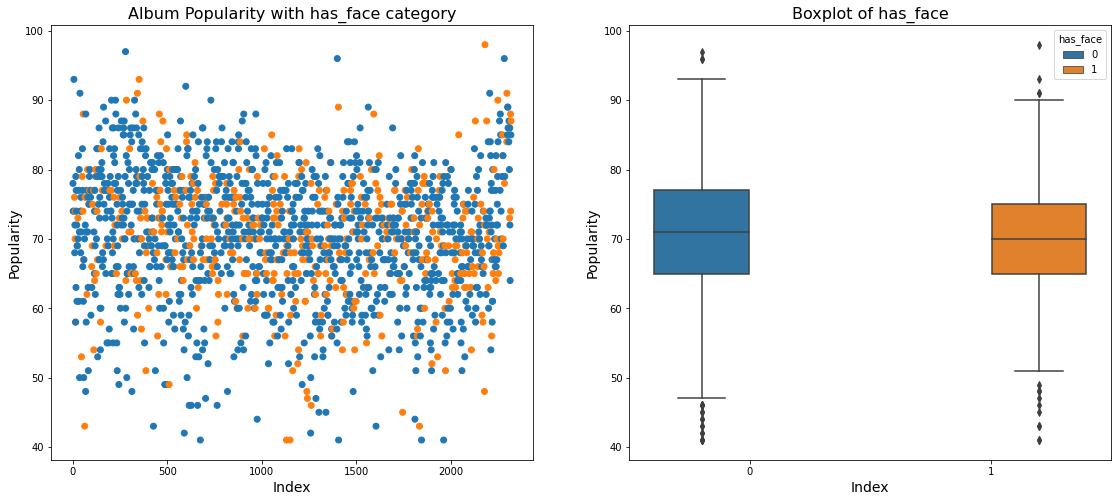

In [205]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(19,8))

x = albums_df.album_popularity
y = x.index
colors = {1:'#ff7f0e', 0:'#1f77b4'}

ax1.scatter(y, x, c = albums_df.has_face.map(colors))


ax1.set_ylabel("Popularity", size = 14)
ax1.set_xlabel("Index", size = 14)
ax1.set_title("Album Popularity with has_face category", size = 16)

ax2 = sns.boxplot(x='has_face', y='album_popularity', 
                 data=albums_df, 
                 palette=colors,
                 hue='has_face')

ax2.set_title("Boxplot of has_face", size = 16)
ax2.set_ylabel("Popularity", size = 14)
ax2.set_xlabel("Index", size = 14)

## 2. Hog Descriptors

In [ ]:
hog = cv2.HOGDescriptor()
h = hog.compute(image)

In [70]:
winSize = (20,20)
blockSize = (10,10)
blockStride = (5,5)
cellSize = (10,10)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
useSignedGradients = True

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels, 
                        useSignedGradients)

(4455, 1)

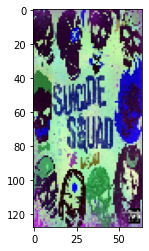

In [71]:
image = cv2.imread(albums_df.filepath[20])
dim = (64, 128)
  
# resize image
resized = cv2.resize(image, dim)
plt.imshow(resized)
h = hog.compute(resized)
h.shape

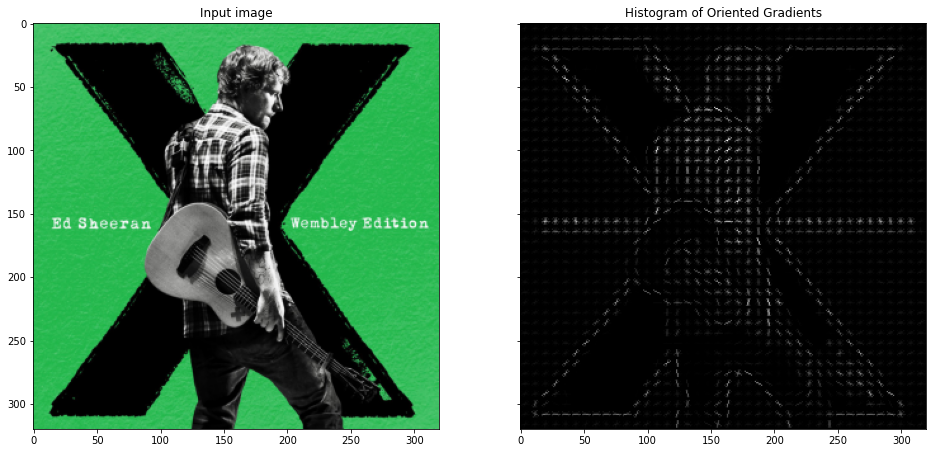

(54756,)

In [79]:
#importing required libraries
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

image = imread(albums_df.filepath[44])

resized_img = resize(image, (320,320)) 
# resized_img = resize(image, (128,64)) 
 

fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(resized_img, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

fd.shape

In [ ]:

y = np.array(albums_df['album_popularity'])
y

X = albums_df['img']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [101]:
X_train.shape

(1856,)

In [175]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

import skimage

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X],  dtype="object")

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X],  dtype="object")
        except:
            return np.array([local_hog(img) for img in X],  dtype="object")

hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)


X_train_gray = RGB2GrayTransformer().fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = StandardScaler().fit_transform(X_train_hog)


<ipython-input-175-9125364e6628>:20: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X],  dtype="object")


In [176]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=2000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)



SGDClassifier(max_iter=2000, random_state=42)

In [181]:
X_test_gray = RGB2GrayTransformer().fit_transform(X_test)
X_test_hog = hogify.fit_transform(X_test_gray)
X_test_prepared = StandardScaler().fit_transform(X_test_hog)

<ipython-input-175-9125364e6628>:20: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([skimage.color.rgb2gray(img) for img in X],  dtype="object")


In [182]:
y_pred = sgd_clf.predict(X_test_prepared)

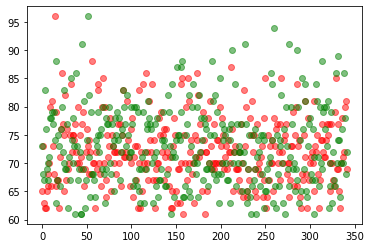

In [190]:
plt.plot(y_pred,'ro', alpha = 0.5)
plt.plot(y_test,'go', alpha = 0.5)

In [187]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score

rms = mean_squared_error(y_test, y_pred, squared=False)

rms

r2_score(y_test, y_pred) 

 
    

 

-0.51595657334478